In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 필요한 모듈을 가져옵니다.

from matplotlib.backends.backend_agg import FigureCanvasAgg

In [2]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

In [3]:
from scheduler_env.customEnv_repeat import SchedulingEnv
from train.train_model import train_model
from train.make_env import make_env

In [4]:
from train.test_model import test_model

In [5]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [16]:
cost_list = [5, 1, 2, 10]
profit_per_time = 15
max_time = 150

env1, env_name = make_env(num_machines = 8, num_jobs = 12, max_repeats = 12, repeat_means = [5] * 12, repeat_stds = [2] * 12, test_mode = False, cost_list = cost_list, profit_per_time = profit_per_time, max_time = max_time)

In [36]:
cost_list = [5, 2, 1, 10]
profit_per_time = 15
max_time = 150

env2, env_name = make_env(num_machines = 8, num_jobs = 12, max_repeats = 12, repeat_means = [5] * 12, repeat_stds = [1] * 12, test_mode = True, cost_list = cost_list, profit_per_time = profit_per_time, max_time = max_time)

In [18]:
# Define your environments (env1 and env2 should be your custom environments)
env1_lambda = lambda: env1
env2_lambda = lambda: env2

# List of environments
env_list = [env1_lambda, env2_lambda]
vec_env = SubprocVecEnv(env_list)  # Or use DummyVecEnv(env_list) for simple parallel execution

In [11]:
model = MaskablePPO.load("MP_Env_8_12_5_1_p15_v2")

In [37]:
env2.show_env_info()

,Operation Type,Total Count,Avg Duration,Std Duration,Machine Count
0,A,45,2.22,1.23,3
1,B,50,1.90,0.54,3
2,C,40,2.12,1.17,3
3,D,50,2.40,1.20,4


In [38]:
env2.show_job_info()

,Job Name,Mean Duration,Std Duration,# of Ops,Mean Deadline,Std Deadline,Repeats
0,Job 1,1.50,0.87,4,19.20,7.110556,5
1,Job 2,2.00,0.82,3,21.20,7.934734,5
2,Job 3,2.33,0.94,3,24.40,11.253444,5
3,Job 4,2.33,1.25,3,22.20,7.934734,5
4,Job 5,2.00,0.82,3,21.20,8.772685,5
5,Job 6,2.00,0.82,3,18.00,7.266361,5
6,Job 7,2.33,1.25,3,21.20,8.975522,5
7,Job 8,3.33,1.70,3,30.20,11.034491,5
8,Job 9,1.67,0.47,3,16.40,7.088018,5
9,Job 10,2.00,0.00,3,21.20,9.537295,5


Current Repeats			:	[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Goal reached! Final score	:	6.60
Total revenue			:	6000.00 - 5604.00 = 396.00
Sum of Costs			:	5604.00
Cost Deadline			:	4020.00
Cost Hole			:	44.00
Cost Processing			:	800.00
Cost Makespan			:	740.00
Finish Time / Target Time	:	7400 / 5000
Average Tardiness:	1265.83


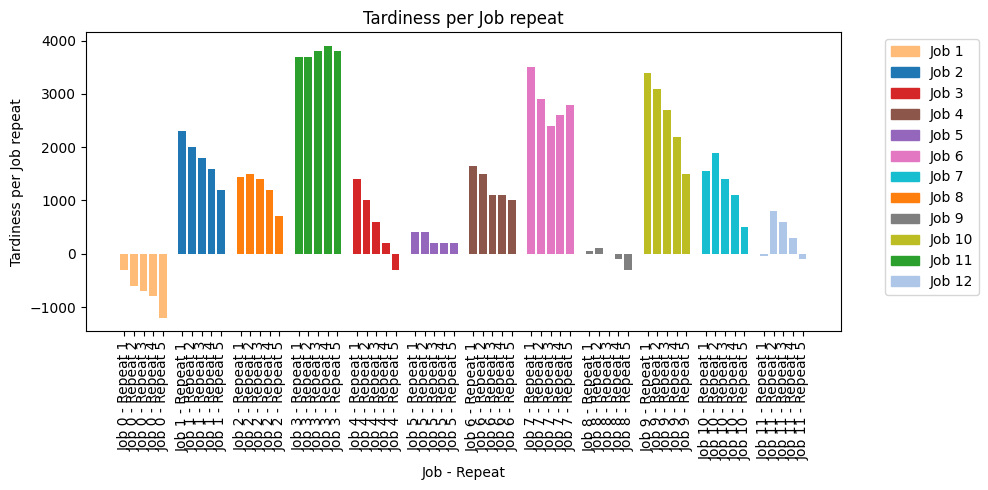

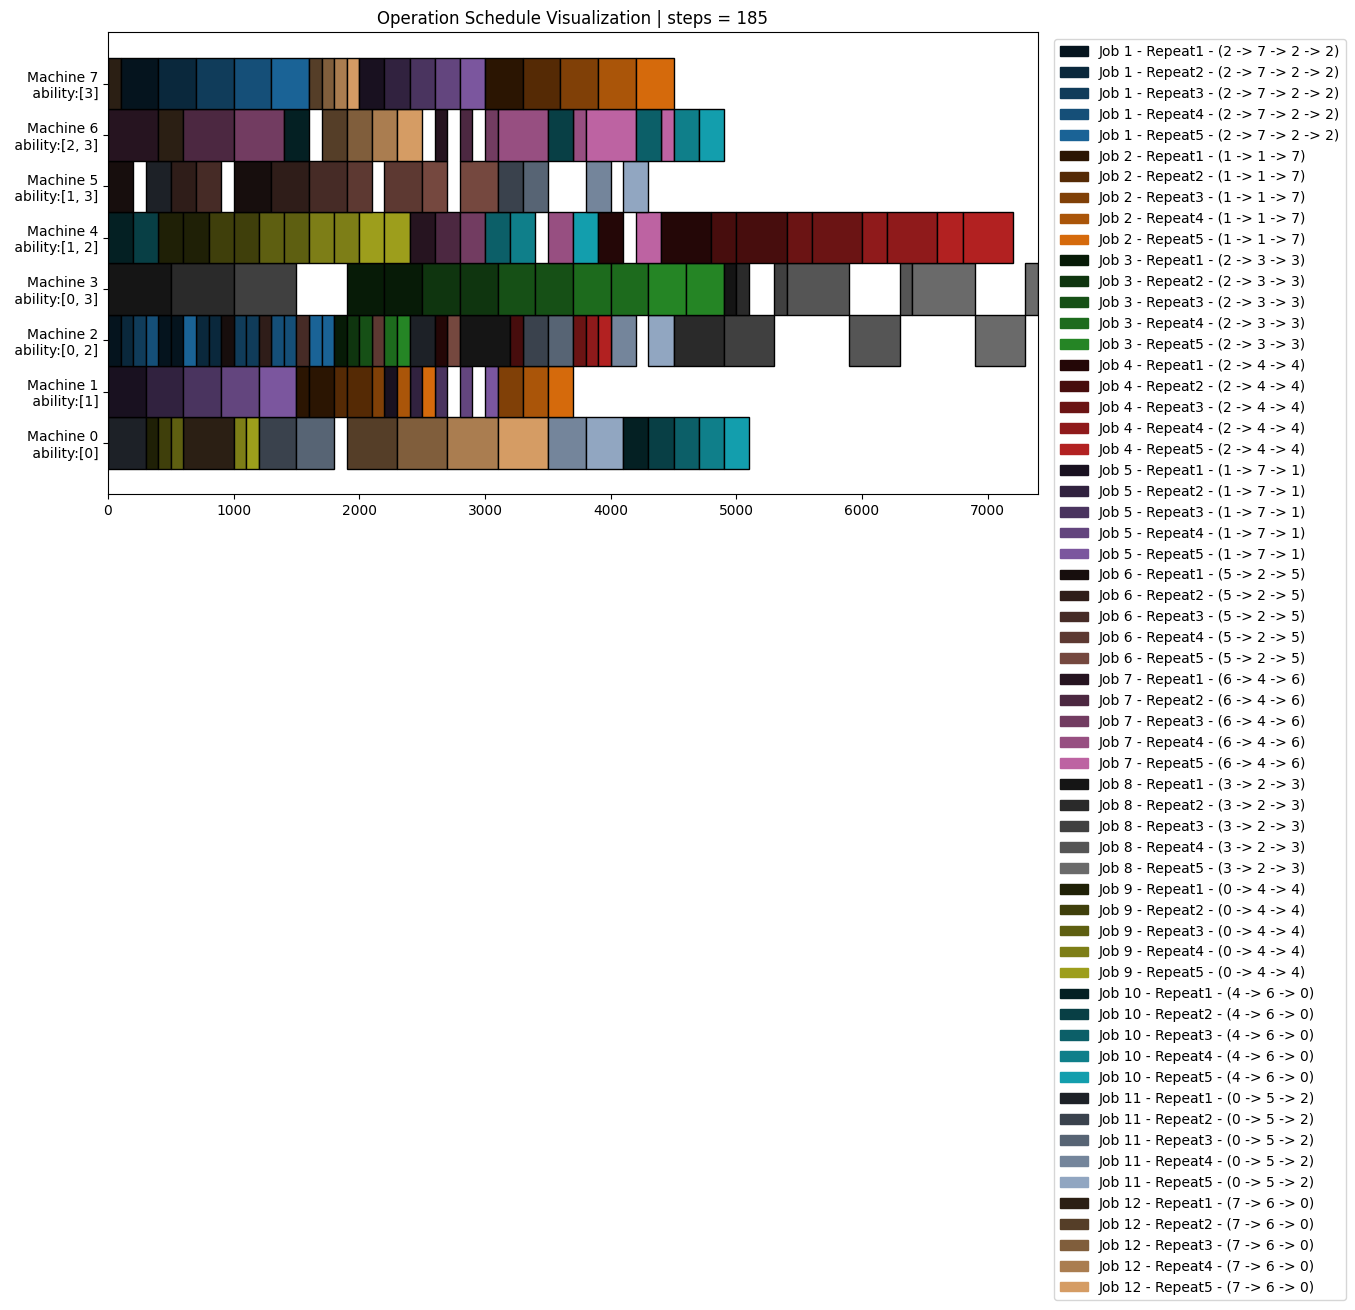




---------------------------Random Simmulation---------------------------
Current Repeats			:	[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Goal reached! Final score	:	-23.13
Total revenue			:	6000.00 - 7388.00 = -1388.00
Sum of Costs			:	7388.00
Cost Deadline			:	5680.00
Cost Hole			:	118.00
Cost Processing			:	800.00
Cost Makespan			:	790.00
Finish Time / Target Time	:	7900 / 5000
Average Tardiness:	1877.50


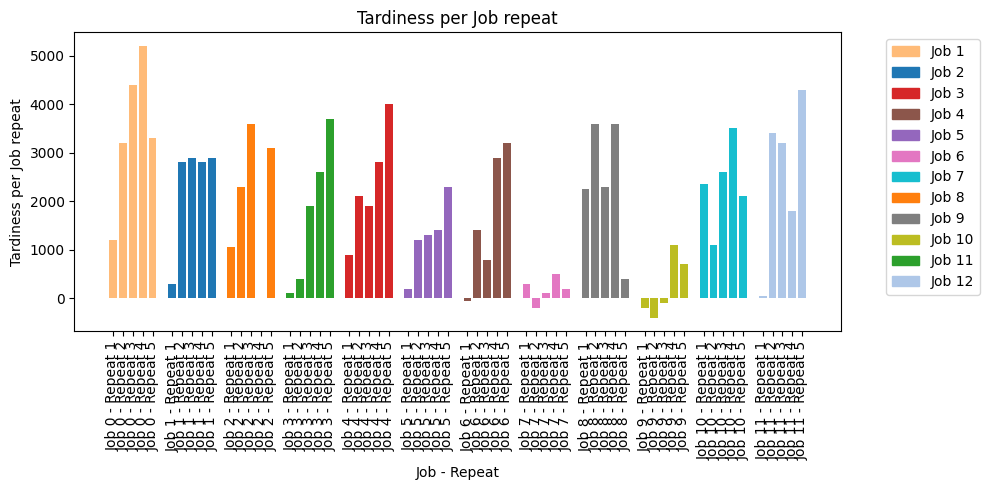

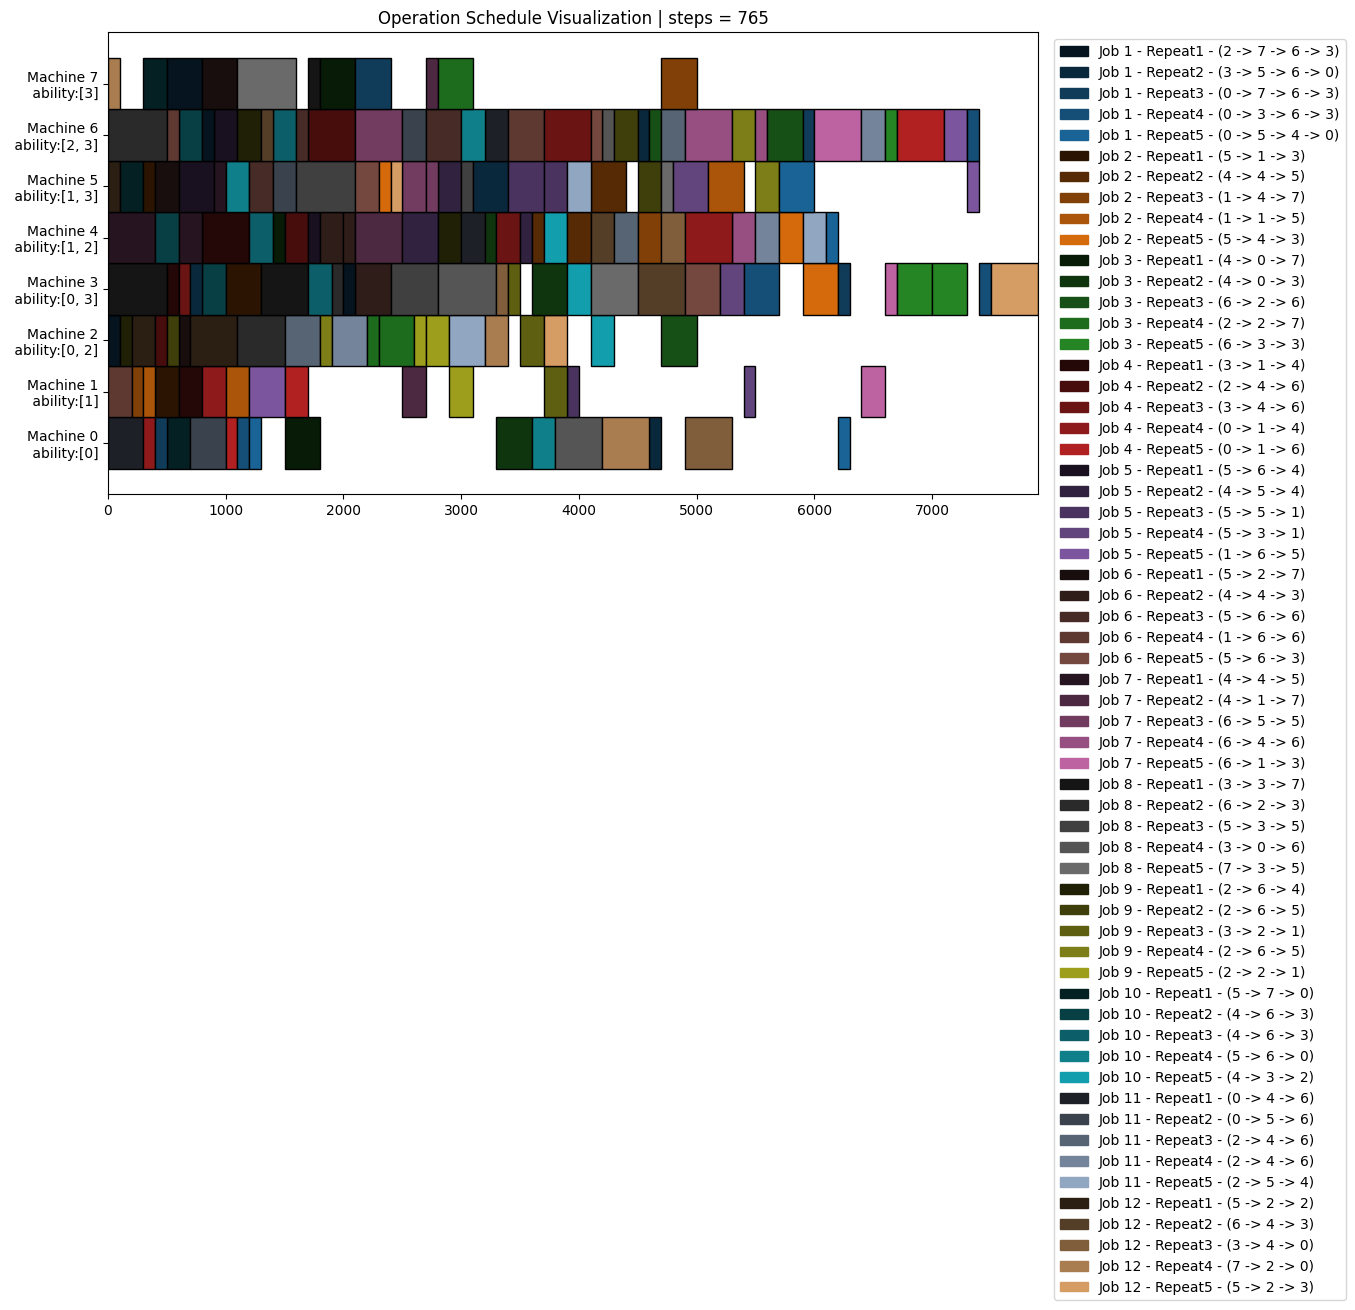

In [12]:
test_model(env = env2, model = model)

In [6]:
cost_list = [5, 1, 2, 10]
profit_per_time = 15
max_time = 150

env1, env_name = make_env(num_machines = 8, num_jobs = 12, max_repeats = 12, repeat_means = [5] * 12, repeat_stds = [1] * 12, test_mode = False, cost_list = cost_list, profit_per_time = profit_per_time, max_time = max_time)

In [7]:
cost_list = [5, 1, 2, 10]
profit_per_time = 15
max_time = 150

env2, env_name = make_env(num_machines = 8, num_jobs = 12, max_repeats = 12, repeat_means = [5] * 12, repeat_stds = [1] * 12, test_mode = True, cost_list = cost_list, profit_per_time = profit_per_time, max_time = max_time)

In [8]:
# Define your environments (env1 and env2 should be your custom environments)
env1_lambda = lambda: env1
env2_lambda = lambda: env2

# List of environments
env_list = [env1_lambda, env2_lambda]
vec_env = SubprocVecEnv(env_list)  # Or use DummyVecEnv(env_list) for simple parallel execution

In [9]:
train_model(vec_env, "Env_8_12_5_1_p15_", version = "v2")

Logging to ./logs/tmp/Env_8_12_5_1_p15_
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 718  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 651         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012159718 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.38       |
|    explained_variance   | 0.0363      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.348       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 3.95        |
-------------------

In [10]:
!tensorboard --logdir=./logs/tmp/Env_8_12_5_1_p15_

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)


Process ForkServerProcess-2:
Process ForkServerProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 33, in _worker
    cmd, data = remote.recv()
                ^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
          ^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/py

^C


In [27]:
# model = train_model(env, env_name, version = "v1")

In [25]:
import os
import shutil

log_dir = "./logs/tmp/env_5_8_5_1"

# 디렉토리 내 모든 파일과 서브 디렉토리 삭제
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
    print(f"{log_dir} 디렉토리와 그 안의 모든 내용이 삭제되었습니다.")
else:
    print(f"{log_dir} 디렉토리가 존재하지 않습니다.")

# 디렉토리 재생성 (필요한 경우)
os.makedirs(log_dir, exist_ok=True)
print(f"{log_dir} 디렉토리가 생성되었습니다.")

./logs/tmp/env_5_8_5_1 디렉토리와 그 안의 모든 내용이 삭제되었습니다.
./logs/tmp/env_5_8_5_1 디렉토리가 생성되었습니다.


In [45]:
# model = MaskablePPO.load("models/MP_test_cost_8_12_8_step")